# Loan Approval / Rejection Model Training

This notebook trains a classifier to predict whether a loan will be **approved** or **rejected** using the [mariosyahirhalimm/loan_prediction_dataset](https://huggingface.co/datasets/mariosyahirhalimm/loan_prediction_dataset) from Hugging Face.

## Pipeline
1. **Load** the dataset with `datasets.load_dataset`
2. **Explore** columns, target, and missing values
3. **Clean** the dataset (handle missing values, outliers, data quality issues)
4. **Visualize** the dataset (distributions, correlations, feature relationships)
5. **Preprocess** (encode categoricals, handle missing values, train/validation split)
6. **Train** a classifier (Random Forest with n_estimators=100 trees, or XGBoost)
7. **Evaluate** with confusion matrix visualizations and detailed metrics
8. **Test** the model with sample predictions
9. **Save** the model and preprocessing components

**Note:** Random Forest and XGBoost use `n_estimators` (number of trees/boosting rounds), not epochs. The model trains 100 trees in a single pass.

## 1. Install dependencies

In [1]:
# Install required packages (run once)
!pip install -q datasets pandas scikit-learn xgboost matplotlib seaborn

## 2. Load the dataset

In [2]:
from datasets import load_dataset

ds = load_dataset("mariosyahirhalimm/loan_prediction_dataset")
ds

/Users/huberttuyishime/Desktop/AgriFinConnect-Rwanda/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/huberttuyishime/Desktop/AgriFinConnect-Rwanda/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DatasetDict({
    train: Dataset({
        features: ['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
        num_rows: 614
    })
})

## 3. Explore the dataset

In [3]:
import pandas as pd

# Use train split if present, else first split
split_name = "train" if "train" in ds else list(ds.keys())[0]
df = ds[split_name].to_pandas()

print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nFirst rows:")
df.head(10)

Shape: (614, 13)

Columns: ['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status']

First rows:


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
5,LP001011,Male,Yes,2,Graduate,Yes,5417,4196.0,267.0,360.0,1.0,Urban,Y
6,LP001013,Male,Yes,0,Not Graduate,No,2333,1516.0,95.0,360.0,1.0,Urban,Y
7,LP001014,Male,Yes,3+,Graduate,No,3036,2504.0,158.0,360.0,0.0,Semiurban,N
8,LP001018,Male,Yes,2,Graduate,No,4006,1526.0,168.0,360.0,1.0,Urban,Y
9,LP001020,Male,Yes,1,Graduate,No,12841,10968.0,349.0,360.0,1.0,Semiurban,N


In [4]:
# Detect target column (common names for loan status)
target_candidates = [c for c in df.columns if "loan" in c.lower() and ("status" in c.lower() or "approv" in c.lower() or "target" in c.lower() or c.lower() == "loan_status")]
if not target_candidates:
    target_candidates = [c for c in df.columns if "label" in c.lower() or "target" in c.lower() or "y" == c.lower()]
if not target_candidates:
    # Fallback: last column is often the target
    target_candidates = [df.columns[-1]]
TARGET_COL = target_candidates[0]
print("Target column:", TARGET_COL)
print(df[TARGET_COL].value_counts())
print("\nInfo & missing:")
print(df.info())
print("\nMissing per column:")
print(df.isnull().sum())

Target column: Loan_Status
Loan_Status
Y    422
N    192
Name: count, dtype: int64

Info & missing:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB
None

Missin

## 3. Clean the dataset


In [5]:
# Data cleaning: Handle missing values, outliers, and data quality issues
import numpy as np

# Create a copy for cleaning
df_clean = df.copy()

print("Before cleaning:")
print(f"Shape: {df_clean.shape}")
print(f"Missing values:\n{df_clean.isnull().sum()}\n")

# 1. Handle missing values in numeric columns
numeric_cols_clean = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']
for col in numeric_cols_clean:
    if col in df_clean.columns:
        # Fill with median for numeric columns
        median_val = df_clean[col].median()
        df_clean[col].fillna(median_val, inplace=True)
        print(f"Filled {col} missing values with median: {median_val:.2f}")

# 2. Handle missing values in categorical columns
categorical_cols_clean = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area']
for col in categorical_cols_clean:
    if col in df_clean.columns:
        # Fill with mode (most frequent value)
        mode_val = df_clean[col].mode()[0] if len(df_clean[col].mode()) > 0 else 'Unknown'
        df_clean[col].fillna(mode_val, inplace=True)
        print(f"Filled {col} missing values with mode: {mode_val}")

# 3. Handle outliers in numeric columns (using IQR method)
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Cap outliers instead of removing (to preserve data size)
    df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)
    return lower_bound, upper_bound

print("\nOutlier handling (capping at 1.5*IQR):")
for col in ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']:
    if col in df_clean.columns:
        lower, upper = remove_outliers_iqr(df_clean, col)
        print(f"{col}: capped between {lower:.2f} and {upper:.2f}")

# 4. Standardize categorical values (remove extra spaces, convert to proper case)
for col in categorical_cols_clean:
    if col in df_clean.columns:
        df_clean[col] = df_clean[col].astype(str).str.strip().str.title()

# 5. Ensure Credit_History is binary (0 or 1)
if 'Credit_History' in df_clean.columns:
    df_clean['Credit_History'] = df_clean['Credit_History'].fillna(1.0)  # Assume good credit if missing
    df_clean['Credit_History'] = df_clean['Credit_History'].astype(int)

print("\nAfter cleaning:")
print(f"Shape: {df_clean.shape}")
print(f"Missing values:\n{df_clean.isnull().sum()}")
print("\nDataset cleaned successfully!")


Before cleaning:
Shape: (614, 13)
Missing values:
Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

Filled ApplicantIncome missing values with median: 3812.50
Filled CoapplicantIncome missing values with median: 1188.50
Filled LoanAmount missing values with median: 128.00
Filled Loan_Amount_Term missing values with median: 360.00
Filled Credit_History missing values with median: 1.00
Filled Gender missing values with mode: Male
Filled Married missing values with mode: Yes
Filled Dependents missing values with mode: 0
Filled Education missing values with mode: Graduate
Filled Self_Employed missing values with mode: No
Filled Property_Area missing values with mode: Semiurban

Outlier handling (capping at 1.5*IQR):
Ap

/var/folders/h6/ywycysfs6gz27mv8tx8mft_40000gn/T/ipykernel_7574/2030841904.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean[col].fillna(median_val, inplace=True)
/var/folders/h6/ywycysfs6gz27mv8tx8mft_40000gn/T/ipykernel_7574/2030841904.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always

## 4. Visualize the dataset


Matplotlib is building the font cache; this may take a moment.


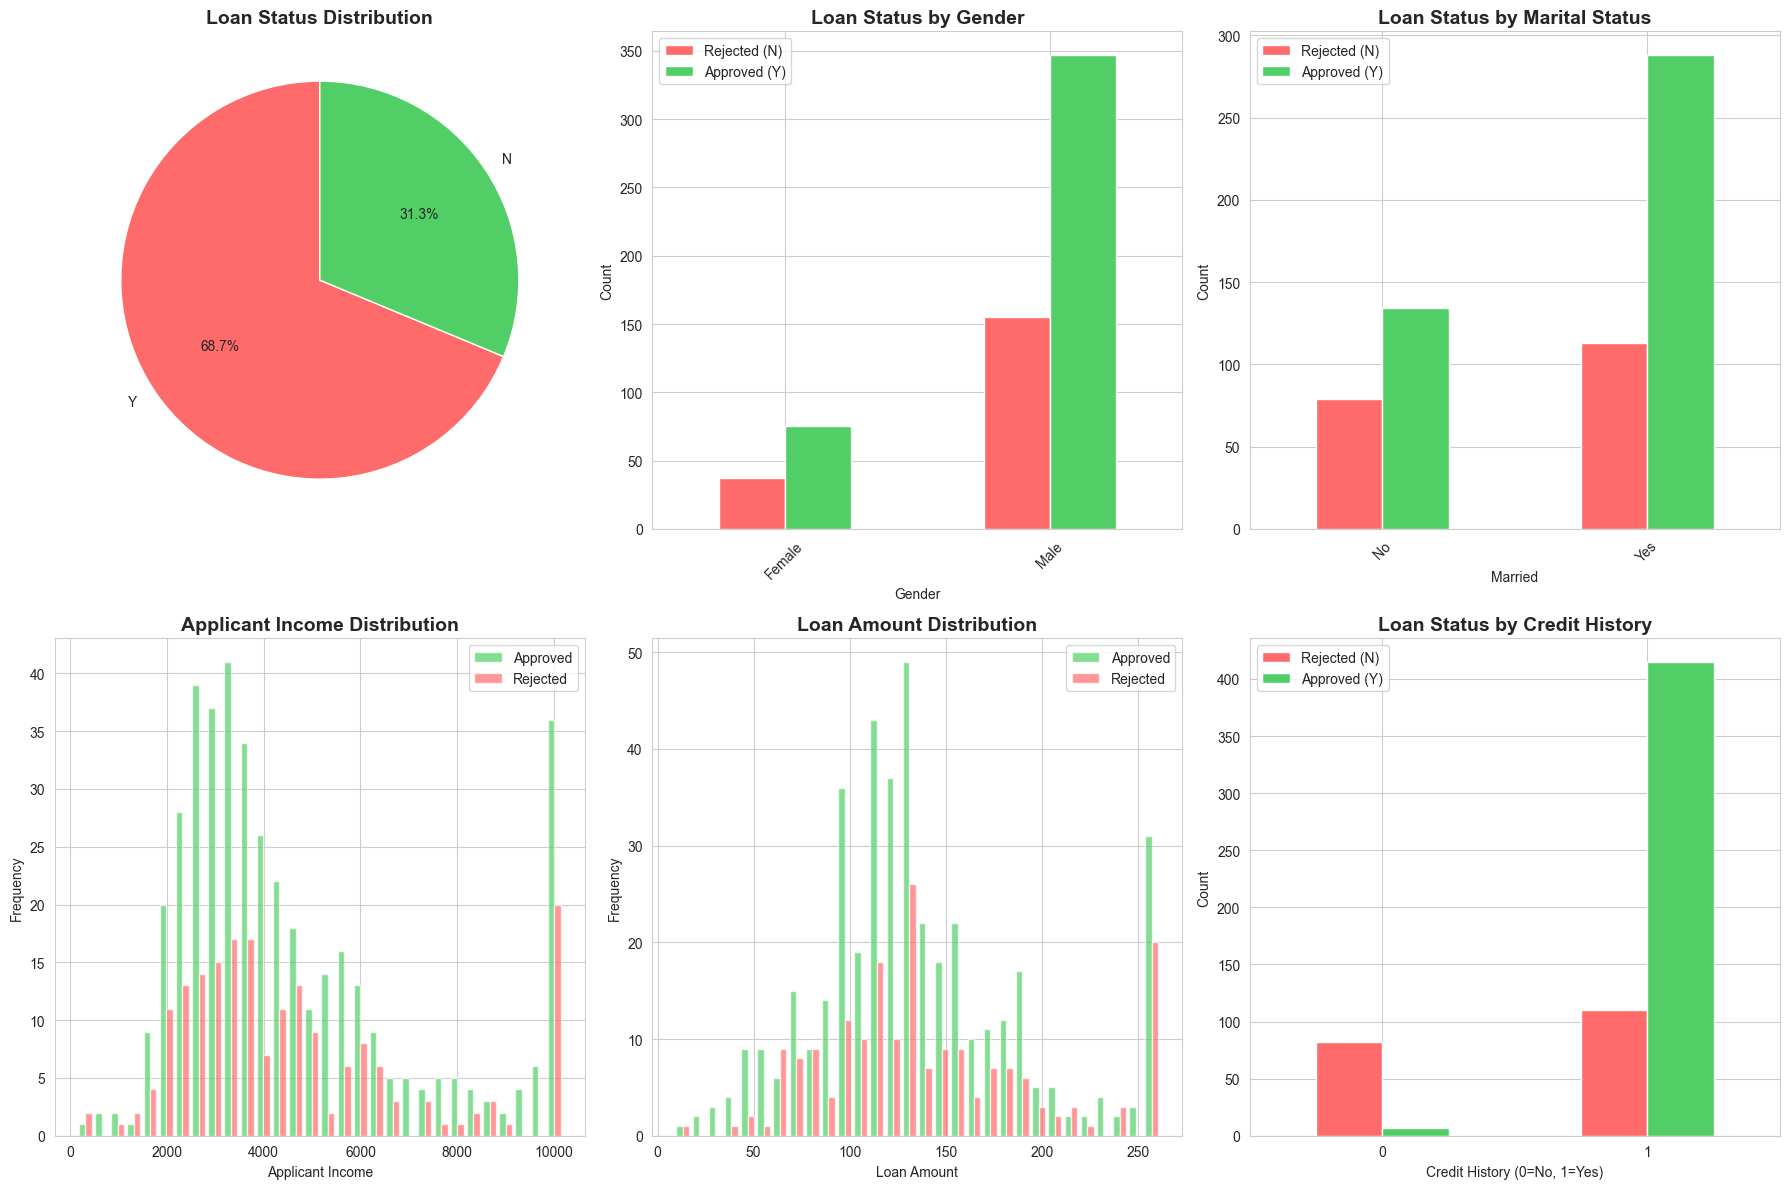

In [6]:
# Dataset visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 10)

# Use cleaned dataset
df_viz = df_clean.copy()

# 1. Target variable distribution
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Target distribution
axes[0, 0].pie(df_viz[TARGET_COL].value_counts(), labels=df_viz[TARGET_COL].value_counts().index, 
               autopct='%1.1f%%', startangle=90, colors=['#ff6b6b', '#51cf66'])
axes[0, 0].set_title('Loan Status Distribution', fontsize=14, fontweight='bold')

# Gender distribution by loan status
if 'Gender' in df_viz.columns:
    pd.crosstab(df_viz['Gender'], df_viz[TARGET_COL]).plot(kind='bar', ax=axes[0, 1], color=['#ff6b6b', '#51cf66'])
    axes[0, 1].set_title('Loan Status by Gender', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Gender')
    axes[0, 1].set_ylabel('Count')
    axes[0, 1].legend(['Rejected (N)', 'Approved (Y)'])
    axes[0, 1].tick_params(axis='x', rotation=45)

# Married status distribution
if 'Married' in df_viz.columns:
    pd.crosstab(df_viz['Married'], df_viz[TARGET_COL]).plot(kind='bar', ax=axes[0, 2], color=['#ff6b6b', '#51cf66'])
    axes[0, 2].set_title('Loan Status by Marital Status', fontsize=14, fontweight='bold')
    axes[0, 2].set_xlabel('Married')
    axes[0, 2].set_ylabel('Count')
    axes[0, 2].legend(['Rejected (N)', 'Approved (Y)'])
    axes[0, 2].tick_params(axis='x', rotation=45)

# Applicant Income distribution
if 'ApplicantIncome' in df_viz.columns:
    axes[1, 0].hist([df_viz[df_viz[TARGET_COL]=='Y']['ApplicantIncome'], 
                     df_viz[df_viz[TARGET_COL]=='N']['ApplicantIncome']], 
                    bins=30, color=['#51cf66', '#ff6b6b'], alpha=0.7, label=['Approved', 'Rejected'])
    axes[1, 0].set_title('Applicant Income Distribution', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Applicant Income')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].legend()

# Loan Amount distribution
if 'LoanAmount' in df_viz.columns:
    axes[1, 1].hist([df_viz[df_viz[TARGET_COL]=='Y']['LoanAmount'], 
                     df_viz[df_viz[TARGET_COL]=='N']['LoanAmount']], 
                    bins=30, color=['#51cf66', '#ff6b6b'], alpha=0.7, label=['Approved', 'Rejected'])
    axes[1, 1].set_title('Loan Amount Distribution', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Loan Amount')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].legend()

# Credit History impact
if 'Credit_History' in df_viz.columns:
    pd.crosstab(df_viz['Credit_History'], df_viz[TARGET_COL]).plot(kind='bar', ax=axes[1, 2], color=['#ff6b6b', '#51cf66'])
    axes[1, 2].set_title('Loan Status by Credit History', fontsize=14, fontweight='bold')
    axes[1, 2].set_xlabel('Credit History (0=No, 1=Yes)')
    axes[1, 2].set_ylabel('Count')
    axes[1, 2].legend(['Rejected (N)', 'Approved (Y)'])
    axes[1, 2].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()


### 4.1. Additional visualizations


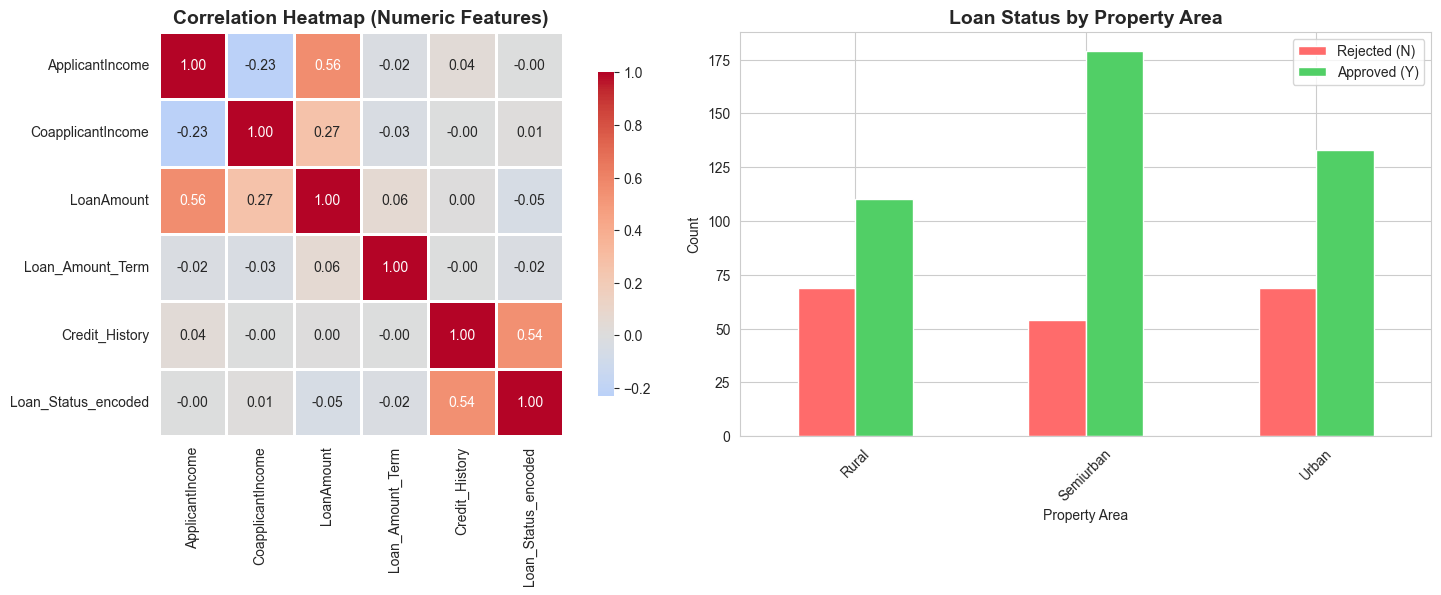

In [7]:
# Additional visualizations: Correlation heatmap and feature importance preview
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Correlation heatmap for numeric features
numeric_for_corr = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']
numeric_df = df_viz[numeric_for_corr + [TARGET_COL]].copy()
# Encode target for correlation
numeric_df[TARGET_COL + '_encoded'] = (numeric_df[TARGET_COL] == 'Y').astype(int)
corr_cols = numeric_for_corr + [TARGET_COL + '_encoded']
corr_matrix = numeric_df[corr_cols].corr()

sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, ax=axes[0])
axes[0].set_title('Correlation Heatmap (Numeric Features)', fontsize=14, fontweight='bold')

# Property Area distribution
if 'Property_Area' in df_viz.columns:
    pd.crosstab(df_viz['Property_Area'], df_viz[TARGET_COL]).plot(kind='bar', ax=axes[1], color=['#ff6b6b', '#51cf66'])
    axes[1].set_title('Loan Status by Property Area', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Property Area')
    axes[1].set_ylabel('Count')
    axes[1].legend(['Rejected (N)', 'Approved (Y)'])
    axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


## 5. Preprocess and prepare features

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import numpy as np

# Use cleaned dataset
df_work = df_clean.copy()

# Drop ID-like columns if present
id_cols = [c for c in df_work.columns if "id" in c.lower() and c != TARGET_COL]
df_work = df_work.drop(columns=id_cols, errors="ignore")

X = df_work.drop(columns=[TARGET_COL])
y_raw = df_work[TARGET_COL]

# Encode target: binary (approved=1, rejected=0)
le_target = LabelEncoder()
y = le_target.fit_transform(y_raw.astype(str))
print("Target classes:", le_target.classes_, "->", np.unique(y))

# Identify numeric vs categorical
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
print("Numeric:", numeric_cols)
print("Categorical:", cat_cols)

# Fill missing: numeric -> median, categorical -> most_frequent
if numeric_cols:
    for c in numeric_cols:
        X[c] = pd.to_numeric(X[c], errors="coerce")
    X[numeric_cols] = X[numeric_cols].fillna(X[numeric_cols].median())
for c in cat_cols:
    X[c] = X[c].fillna(X[c].mode().iloc[0] if len(X[c].mode()) else "Unknown")
    X[c] = LabelEncoder().fit_transform(X[c].astype(str))

feature_cols = numeric_cols + cat_cols
X = X[feature_cols]

# Train/validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
print("\nTrain size:", X_train.shape[0], "Val size:", X_val.shape[0])

Target classes: ['N' 'Y'] -> [0 1]
Numeric: ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']
Categorical: ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area']

Train size: 491 Val size: 123


## 6. Train the classifier

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Note: Random Forest doesn't use "epochs" - it uses n_estimators (number of trees)
# n_estimators=100 means 100 decision trees will be trained
print("Training Random Forest Classifier...")
print("Note: Random Forest uses n_estimators (number of trees), not epochs.")
print(f"Training with n_estimators=100 trees, max_depth=10\n")

model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_val)
print("Accuracy:", accuracy_score(y_val, y_pred))
print("\nClassification report:")
print(classification_report(y_val, y_pred, target_names=le_target.classes_.tolist()))
print("\nConfusion matrix:")
cm = confusion_matrix(y_val, y_pred)
print(cm)

Training Random Forest Classifier...
Note: Random Forest uses n_estimators (number of trees), not epochs.
Training with n_estimators=100 trees, max_depth=10

Accuracy: 0.8211382113821138

Classification report:
              precision    recall  f1-score   support

           N       0.79      0.58      0.67        38
           Y       0.83      0.93      0.88        85

    accuracy                           0.82       123
   macro avg       0.81      0.75      0.77       123
weighted avg       0.82      0.82      0.81       123


Confusion matrix:
[[22 16]
 [ 6 79]]


## 7. (Optional) XGBoost alternative

Training XGBoost Classifier...
Note: XGBoost uses n_estimators (boosting rounds), not epochs.
Training with n_estimators=100 boosting rounds, max_depth=6

XGBoost Accuracy: 0.7886178861788617
              precision    recall  f1-score   support

           N       0.66      0.66      0.66        38
           Y       0.85      0.85      0.85        85

    accuracy                           0.79       123
   macro avg       0.75      0.75      0.75       123
weighted avg       0.79      0.79      0.79       123



/Users/huberttuyishime/Desktop/AgriFinConnect-Rwanda/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:58:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


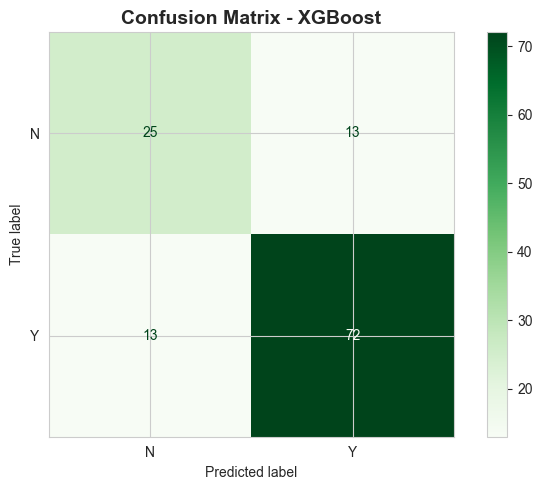

In [10]:
try:
    import xgboost as xgb
    # Note: XGBoost also uses n_estimators (number of boosting rounds), not epochs
    print("Training XGBoost Classifier...")
    print("Note: XGBoost uses n_estimators (boosting rounds), not epochs.")
    print(f"Training with n_estimators=100 boosting rounds, max_depth=6\n")
    
    xgb_model = xgb.XGBClassifier(n_estimators=100, max_depth=6, random_state=42, use_label_encoder=False, eval_metric="logloss")
    xgb_model.fit(X_train, y_train)
    y_pred_xgb = xgb_model.predict(X_val)
    print("XGBoost Accuracy:", accuracy_score(y_val, y_pred_xgb))
    print(classification_report(y_val, y_pred_xgb, target_names=le_target.classes_.tolist()))
    
    # Visualize XGBoost confusion matrix
    from sklearn.metrics import ConfusionMatrixDisplay
    cm_xgb = confusion_matrix(y_val, y_pred_xgb)
    fig, ax = plt.subplots(1, 1, figsize=(7, 5))
    disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=le_target.classes_)
    disp_xgb.plot(ax=ax, cmap='Greens', values_format='d')
    ax.set_title('Confusion Matrix - XGBoost', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
except ImportError:
    print("XGBoost not installed. Using Random Forest only.")

## 8. Evaluate model performance


### 8.1. Feature importance analysis


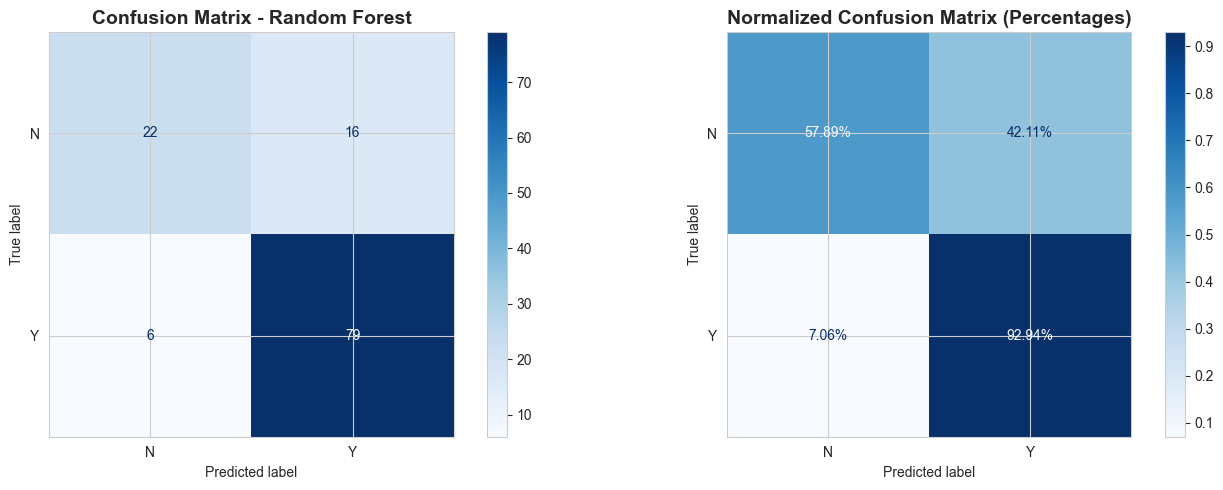


Detailed Performance Metrics:
True Negatives (TN): 22 - Correctly predicted Rejected loans
False Positives (FP): 16 - Incorrectly predicted as Approved (Type I Error)
False Negatives (FN): 6 - Incorrectly predicted as Rejected (Type II Error)
True Positives (TP): 79 - Correctly predicted Approved loans

Sensitivity (Recall/TPR): 0.929 - Ability to detect approved loans
Specificity (TNR): 0.579 - Ability to detect rejected loans
Precision: 0.832 - Accuracy of approved predictions
F1-Score: 0.878 - Harmonic mean of precision and recall


In [11]:
# Visualize confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Create confusion matrix visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Standard confusion matrix
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le_target.classes_)
disp.plot(ax=axes[0], cmap='Blues', values_format='d')
axes[0].set_title('Confusion Matrix - Random Forest', fontsize=14, fontweight='bold')

# Normalized confusion matrix (percentages)
cm_normalized = confusion_matrix(y_val, y_pred, normalize='true')
disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=le_target.classes_)
disp_norm.plot(ax=axes[1], cmap='Blues', values_format='.2%')
axes[1].set_title('Normalized Confusion Matrix (Percentages)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Print detailed metrics
tn, fp, fn, tp = cm.ravel()
print("\nDetailed Performance Metrics:")
print(f"True Negatives (TN): {tn} - Correctly predicted Rejected loans")
print(f"False Positives (FP): {fp} - Incorrectly predicted as Approved (Type I Error)")
print(f"False Negatives (FN): {fn} - Incorrectly predicted as Rejected (Type II Error)")
print(f"True Positives (TP): {tp} - Correctly predicted Approved loans")
print(f"\nSensitivity (Recall/TPR): {tp/(tp+fn):.3f} - Ability to detect approved loans")
print(f"Specificity (TNR): {tn/(tn+fp):.3f} - Ability to detect rejected loans")
print(f"Precision: {tp/(tp+fp):.3f} - Accuracy of approved predictions")
print(f"F1-Score: {2*tp/(2*tp+fp+fn):.3f} - Harmonic mean of precision and recall")


/var/folders/h6/ywycysfs6gz27mv8tx8mft_40000gn/T/ipykernel_7574/4077721036.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance, x='importance', y='feature', palette='viridis')


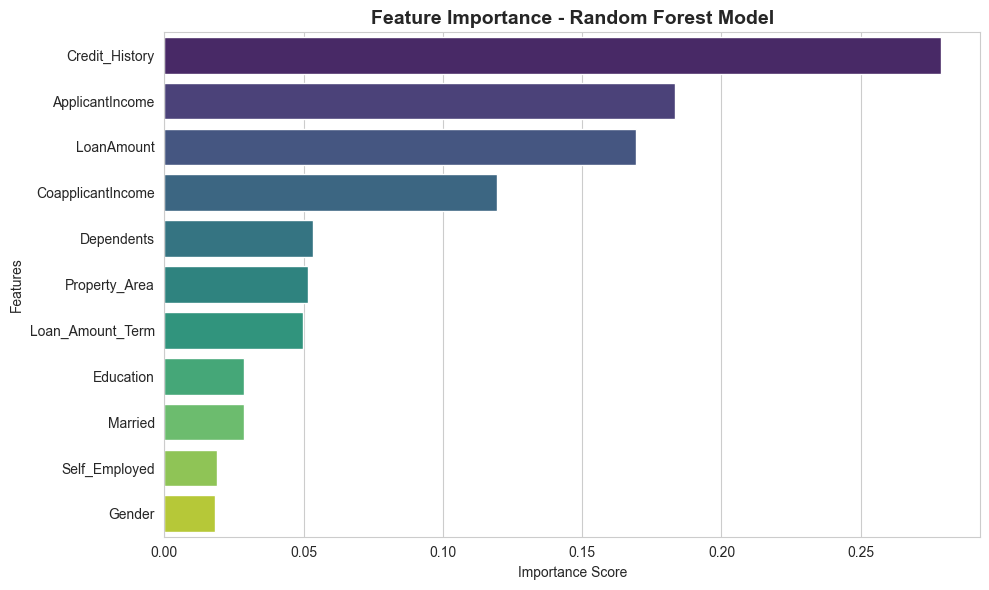


Top 5 Most Important Features:
          feature  importance
   Credit_History    0.278868
  ApplicantIncome    0.183446
       LoanAmount    0.169407
CoapplicantIncome    0.119396
       Dependents    0.053351


In [12]:
# Additional testing: Feature importance visualization
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='importance', y='feature', palette='viridis')
plt.title('Feature Importance - Random Forest Model', fontsize=14, fontweight='bold')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

print("\nTop 5 Most Important Features:")
print(feature_importance.head(5).to_string(index=False))


## 9. Test the model with sample predictions


In [13]:
# Test the model with sample loan applications
import pandas as pd

def predict_loan_approval(model, scaler, le_target, feature_cols, applicant_data):
    """
    Predict loan approval for a new applicant.
    
    Parameters:
    - model: Trained classifier
    - scaler: Fitted StandardScaler
    - le_target: Fitted LabelEncoder for target
    - feature_cols: List of feature column names in order
    - applicant_data: Dictionary with applicant information
    
    Returns:
    - prediction: 'Y' (Approved) or 'N' (Rejected)
    - probability: Probability of approval
    """
    # Create DataFrame from applicant data
    df_applicant = pd.DataFrame([applicant_data])
    
    # Prepare features in the same order as training
    X_applicant = pd.DataFrame(columns=feature_cols)
    
    for col in feature_cols:
        if col in df_applicant.columns:
            X_applicant[col] = df_applicant[col]
        else:
            # Fill missing with default values
            if col in numeric_cols:
                X_applicant[col] = df_clean[col].median()
            else:
                X_applicant[col] = df_clean[col].mode()[0] if len(df_clean[col].mode()) > 0 else 'Unknown'
    
    # Encode categorical variables (using the same encoding as training)
    for col in cat_cols:
        if col in X_applicant.columns:
            # Use the same label encoders (in practice, save and load them)
            le_temp = LabelEncoder()
            le_temp.fit(df_clean[col].astype(str))
            X_applicant[col] = le_temp.transform(X_applicant[col].astype(str))
    
    # Scale features
    X_applicant_scaled = scaler.transform(X_applicant)
    
    # Predict
    prediction_encoded = model.predict(X_applicant_scaled)[0]
    probability = model.predict_proba(X_applicant_scaled)[0]
    
    # Decode prediction
    prediction = le_target.inverse_transform([prediction_encoded])[0]
    prob_approved = probability[1] if prediction_encoded == 1 else probability[0]
    
    return prediction, prob_approved

# Test cases
print("=" * 60)
print("TESTING THE LOAN APPROVAL MODEL")
print("=" * 60)

# Test Case 1: High-income applicant with good credit
test_case_1 = {
    'Gender': 'Male',
    'Married': 'Yes',
    'Dependents': '0',
    'Education': 'Graduate',
    'Self_Employed': 'No',
    'ApplicantIncome': 15000,
    'CoapplicantIncome': 5000,
    'LoanAmount': 200,
    'Loan_Amount_Term': 360,
    'Credit_History': 1,
    'Property_Area': 'Urban'
}

pred1, prob1 = predict_loan_approval(model, scaler, le_target, feature_cols, test_case_1)
print("\nTest Case 1: High-income applicant with good credit")
print(f"  Prediction: {'APPROVED' if pred1 == 'Y' else 'REJECTED'}")
print(f"  Confidence: {prob1*100:.2f}%")
print(f"  Details: Income={test_case_1['ApplicantIncome']}, Credit History={test_case_1['Credit_History']}")

# Test Case 2: Low-income applicant with poor credit
test_case_2 = {
    'Gender': 'Female',
    'Married': 'No',
    'Dependents': '2',
    'Education': 'Not Graduate',
    'Self_Employed': 'Yes',
    'ApplicantIncome': 2000,
    'CoapplicantIncome': 0,
    'LoanAmount': 500,
    'Loan_Amount_Term': 360,
    'Credit_History': 0,
    'Property_Area': 'Rural'
}

pred2, prob2 = predict_loan_approval(model, scaler, le_target, feature_cols, test_case_2)
print("\nTest Case 2: Low-income applicant with poor credit")
print(f"  Prediction: {'APPROVED' if pred2 == 'Y' else 'REJECTED'}")
print(f"  Confidence: {prob2*100:.2f}%")
print(f"  Details: Income={test_case_2['ApplicantIncome']}, Credit History={test_case_2['Credit_History']}")

# Test Case 3: Medium-income applicant with good credit
test_case_3 = {
    'Gender': 'Male',
    'Married': 'Yes',
    'Dependents': '1',
    'Education': 'Graduate',
    'Self_Employed': 'No',
    'ApplicantIncome': 6000,
    'CoapplicantIncome': 2000,
    'LoanAmount': 150,
    'Loan_Amount_Term': 360,
    'Credit_History': 1,
    'Property_Area': 'Semiurban'
}

pred3, prob3 = predict_loan_approval(model, scaler, le_target, feature_cols, test_case_3)
print("\nTest Case 3: Medium-income applicant with good credit")
print(f"  Prediction: {'APPROVED' if pred3 == 'Y' else 'REJECTED'}")
print(f"  Confidence: {prob3*100:.2f}%")
print(f"  Details: Income={test_case_3['ApplicantIncome']}, Credit History={test_case_3['Credit_History']}")

print("\n" + "=" * 60)
print("Model testing completed!")
print("=" * 60)


TESTING THE LOAN APPROVAL MODEL

Test Case 1: High-income applicant with good credit
  Prediction: APPROVED
  Confidence: 68.64%
  Details: Income=15000, Credit History=1

Test Case 2: Low-income applicant with poor credit
  Prediction: REJECTED
  Confidence: 72.00%
  Details: Income=2000, Credit History=0

Test Case 3: Medium-income applicant with good credit
  Prediction: APPROVED
  Confidence: 87.63%
  Details: Income=6000, Credit History=1

Model testing completed!


## 10. Save the model and encoders

In [14]:
import joblib
from pathlib import Path

OUTPUT_DIR = Path("loan_approval_model")
OUTPUT_DIR.mkdir(exist_ok=True)

joblib.dump(model, OUTPUT_DIR / "loan_classifier.joblib")
joblib.dump(le_target, OUTPUT_DIR / "label_encoder.joblib")
joblib.dump(scaler, OUTPUT_DIR / "scaler.joblib")
joblib.dump(feature_cols, OUTPUT_DIR / "feature_columns.joblib")

print("Saved to", OUTPUT_DIR)
print("Files:", list(OUTPUT_DIR.iterdir()))

Saved to loan_approval_model
Files: [PosixPath('loan_approval_model/feature_columns.joblib'), PosixPath('loan_approval_model/scaler.joblib'), PosixPath('loan_approval_model/label_encoder.joblib'), PosixPath('loan_approval_model/loan_classifier.joblib')]
